In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

# We use [Titanic Data at Kaggle](https://www.kaggle.com/c/titanic)

In [5]:
d = pd.read_csv("/Users/rlx/Downloads/train.csv")
print (d.shape)

(891, 12)


In [6]:
d.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Understand `NaN` values are present**

In [8]:
for i in d.columns:
    print ("%20s"%i, np.sum(d[i].isna()))

         PassengerId 0
            Survived 0
              Pclass 0
                Name 0
                 Sex 0
                 Age 177
               SibSp 0
               Parch 0
              Ticket 0
                Fare 0
               Cabin 687
            Embarked 2


In [9]:
d.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

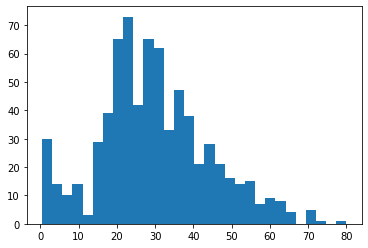

In [10]:
plt.hist(d.Age.dropna().values, bins=30);

**Remove uninformative columns**

In [11]:
del(d["PassengerId"])
del(d["Name"])
del(d["Ticket"])
del(d["Cabin"])


**Fix `NaN` values**

- observe the different filling policies we decide to have

In [12]:
d["Embarked"] = d.Embarked.fillna("N")
d["Age"]      = d.Age.fillna(d.Age.mean())
d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


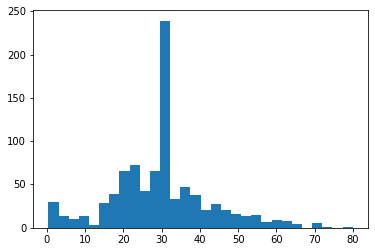

In [13]:
plt.hist(d.Age.dropna().values, bins=30);

**Turn categorical columns to a `one_hot` encoding**

In [14]:
def to_onehot(x):
    values = np.unique(x)
    r = np.r_[[np.argwhere(i==values)[0][0] for i in x]]
    return np.eye(len(values))[r].astype(int)
    
k = to_onehot(d.Embarked.values)
k[:5]

array([[0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

In [15]:
def replace_columns_with_onehot(d, col):
    k = to_onehot(d[col].values)
    r = pd.DataFrame(k, columns=["%s_%d"%(col, i) for i in range(k.shape[1])], index=d.index).join(d)
    del(r[col])
    return r 

In [16]:
d.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [17]:
d = replace_columns_with_onehot(d, "Embarked")
d.head()

,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,0,0,1,0,3,male,22.0,1,0,7.2500
1,1,0,0,0,1,1,female,38.0,1,0,71.2833
2,0,0,0,1,1,3,female,26.0,0,0,7.9250
3,0,0,0,1,1,1,female,35.0,1,0,53.1000
4,0,0,0,1,0,3,male,35.0,0,0,8.0500


In [18]:
d = replace_columns_with_onehot(d, "Sex")
d.head()

,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Embarked_3,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,1,0,0,0,1,0,3,22.0,1,0,7.2500
1,1,0,1,0,0,0,1,1,38.0,1,0,71.2833
2,1,0,0,0,0,1,1,3,26.0,0,0,7.9250
3,1,0,0,0,0,1,1,1,35.0,1,0,53.1000
4,0,1,0,0,0,1,0,3,35.0,0,0,8.0500


In [20]:
d.shape, d.values.sum()

((891, 12), 60142.86312352941)

### Put all transformations together

In [21]:
def clean_titanic(d):
    del(d["PassengerId"])
    del(d["Name"])
    del(d["Ticket"])
    del(d["Cabin"])
    d["Embarked"] = d.Embarked.fillna("N")
    d["Fare"]     = d.Fare.fillna(d.Fare.mean())
    d["Age"]      = d.Age.fillna(d.Age.mean())
    d = replace_columns_with_onehot(d, "Embarked")
    d = replace_columns_with_onehot(d, "Sex")
    return d

**transform train and test data together**

- observe that test data **does not have** a `Survival` column. This is the result to submit to Kaggle

In [22]:
dtr = pd.read_csv("/Users/rlx/Downloads/train.csv")
dts = pd.read_csv("/Users/rlx/Downloads/test.csv")
lentr = len(dtr)
dtr.shape, dts.shape

((891, 12), (418, 11))

In [23]:
dts.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**get data ready for training**

In [25]:
source_cols = [i for i in dtr.columns if i!="Survived"]
all_data = pd.concat((dtr[source_cols], dts[source_cols]))
all_data.index = range(len(all_data))
all_data = clean_titanic(all_data)

Xtr, ytr = all_data.iloc[:lentr].values, dtr["Survived"].values
Xts      = all_data.iloc[lentr:].values

print (Xtr.shape, ytr.shape)
print (Xts.shape)

(891, 11) (891,)
(418, 11)


**cross validate for model selection**

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier()
print (cross_val_score(rf, Xtr, ytr))

svc = SVC()
print (cross_val_score(svc, Xtr, ytr))

[0.79329609 0.79775281 0.85955056 0.76966292 0.83707865]
[0.59217877 0.71348315 0.69101124 0.68539326 0.69101124]


**now train with full dataset and generate submission for Kaggle**

In [29]:
rf.fit(Xtr, ytr)
preds_ts = rf.predict(Xts)
preds_ts

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

**get predictions ready to submit to Kaggle**

- see https://www.kaggle.com/c/titanic#evaluation for file format

In [30]:
submission = pd.DataFrame([dts.PassengerId, pd.Series(preds_ts, name="Survived")]).T
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [31]:
submission.to_csv("/tmp/titanic_kaggle.csv", index=False)

In [32]:
!head /tmp/titanic_kaggle.csv

PassengerId,Survived
892,0
893,0
894,0
895,1
896,1
897,0
898,0
899,0
900,1


In [34]:
!cp /tmp/titanic_kaggle.csv /Users/rlx/Desktop/tmp/